In [1]:
import os
import time
import pandas as pd
import numpy as np
import nltk
import pickle
import json
import sys
sys.setrecursionlimit(10000000)
import re ### to use extended regex library: https://pypi.org/project/regex/
import ast
import csv
from bs4 import BeautifulSoup
import requests
import getpass
from urllib.request import urlopen
from google.colab import files

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

!pip install --ignore-installed --index-url https://test.pypi.org/simple/ --no-deps sddk ### our own package under construction, always install to have up-to-date version
import sddk

Looking in indexes: https://test.pypi.org/simple/


In [0]:
### authorize google sheets
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
# establish connection with particular sheet by its url:

# RESULTS SPREADSHEET
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1v99i42xd9jh0E9O_0-SrCrYE8WI91yQWB03BtJUm97w/edit?usp=sharing")


# sciencedata.dk configuration

As a data storage, we will use Danish official infrastructure called sciencedata.dk. It is commobly approacheble from any European research institution.

The configuration require having already a proper username and password configurated on the web interface of the platform.

In [3]:
s, sciencedata_groupurl = sddk.configure_session_and_url("direct_root")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
personal connection established
group connection established with you as owner
endpoint for requests has been configured to: https://sciencedata.dk/files/direct_root/


# Word Embeddings

In [4]:
### import and inspect data
GNT_gospels_cleaned = json.loads(s.get(sciencedata_groupurl + "dirgot_data/GNT_gospels_cleaned.json").content)
gospels_cleaned = json.loads(s.get(sciencedata_groupurl + "dirgot_data/gospels_cleaned.json").content)
gospels_cleaned["matt"]["verses"][:5]

[['let it be so now for thus it is fitting for us to fulfil all righteousness',
  ['let', 'thus', 'fit', 'you', 'fulfil', 'righteousness']],
 ['it is written man will not live by bread alone but by every word that proceeds from the mouth of god',
  ['write',
   'man',
   'live',
   'bread',
   'alone',
   'every',
   'word',
   'proceed',
   'mouth',
   'god']],
 ['again it is written you will not tempt the lord your god',
  ['write', 'tempt', 'lord', 'god']],
 ['begone satan for it is written you will worship the lord your god and him only will you serve',
  ['begone', 'satan', 'write', 'worship', 'lord', 'god', 'serve']],
 ['repent for the kingdom of heaven is at hand',
  ['repent', 'kingdom', 'heaven', 'hand']]]

In [0]:
### input format for gensim is a list of list
sentences_john_gnt = [verse for verse in GNT_gospels_cleaned["john"][0]]
sentences_john = [verse[1] for verse in gospels_cleaned["john"]["verses"]]
sentences_thom = [verse[1] for verse in gospels_cleaned["thom"]["verses"]]

# Terms of special interest


In [90]:
words_john = [word_tup[0] for word_tup in nltk.FreqDist(gospels_cleaned["john"]["words"]).most_common() if word_tup[1] > 1]
words_thom = [word_tup[0] for word_tup in nltk.FreqDist(gospels_cleaned["thom"]["words"]).most_common() if word_tup[1] > 1]
words_john_gnt = [word_tup[0] for word_tup in nltk.FreqDist(GNT_gospels_cleaned["john"][1]).most_common() if word_tup[1] > 1]
words_overlap = set(words_john) & set(words_thom)
print("total_john: " + str(len(words_john)) + ", total_thom: " + str(len(words_thom)) + ", overlapping words: " + str(len(words_overlap)) + ", total john - gnt: " + str(len(words_john_gnt)))

total_john: 284, total_thom: 277, overlapping words: 123, total john - gnt: 293


In [42]:
### words in both gospels
print(words_overlap)

{'word', 'brother', 'son', 'good', 'destroy', 'ever', 'set', 'holy', 'peace', 'pray', 'others', 'die', 'desire', 'sin', 'go', 'thing', 'bear', 'begin', 'tree', 'child', 'fill', 'way', 'show', 'little', 'away', 'become', 'bring', 'fruit', 'persecute', 'live', 'leave', 'manifest', 'cast', 'make', 'even', 'already', 'draw', 'kill', 'choose', 'enter', 'many', 'come', 'full', 'three', 'drink', 'stone', 'gather', 'time', 'may', 'give', 'dead', 'hebe', 'upon', 'harvest', 'would', 'hand', 'dwell', 'bless', 'send', 'put', 'home', 'power', 'woman', 'flesh', 'say', 'closet', 'might', 'wish', 'hear', 'let', 'forgive', 'take', 'servant', 'sabbath', 'man', 'another', 'forth', 'spirit', 'father', 'among', 'throw', 'blind', 'yet', 'kingdom', 'love', 'disciple', 'afraid', 'light', 'ask', 'trouble', 'heaven', 'therefore', 'tell', 'evil', 'one', 'house', 'world', 'true', 'master', 'know', 'foot', 'see', 'ebeh', 'god', 'nothing', 'place', 'truly', 'neither', 'eat', 'fall', 'day', 'sheep', 'find', 'receive

In [0]:
terms_to_consider = ["world", "begin", "light", "darkness", "flesh", "spirit", "knowledge", "understand", "father", "know", "seek","find", "water", "spring", "vine", "shepherd", "sheep", "fish", "net"]

In [12]:
### let's look at it more closely
for word in terms_to_consider:
  if word in words_overlap:
    print(word, " - BOTH")
  else:
    if word in words_john:
      print(word, " - john")
    if word in words_thom:
      print(word, " - thom")

world  - BOTH
begin  - BOTH
light  - BOTH
darkness  - john
flesh  - BOTH
spirit  - BOTH
understand  - john
father  - BOTH
know  - BOTH
seek  - BOTH
find  - BOTH
water  - john
vine  - john
shepherd  - john
sheep  - BOTH
fish  - BOTH


In [13]:
terms_to_analyze = set(terms_to_consider) & words_overlap
print(terms_to_analyze)

{'light', 'father', 'seek', 'world', 'sheep', 'find', 'flesh', 'begin', 'know', 'fish', 'spirit'}


In [0]:
### to have both nicely in an alphabetic order
terms_to_analyze = sorted(terms_to_analyze)
words_overlap = sorted(words_overlap)

In [0]:
### 
terms_to_analyze = ['begin', 'father', 'find','light', 'seek', 'understand', 'world']

# Greek Terms

In [0]:
### nltk.FreqDist(GNT_gospels_cleaned["john"][1]).most_common(100)

In [0]:
import xml.etree.cElementTree as ET
import unicodedata

### we want the terms with translation
### Dodson's dictionary parsed using Beautiful Soup
url = "https://raw.githubusercontent.com/biblicalhumanities/Dodson-Greek-Lexicon/master/dodson.xml"
primary_dict = {}
page = urlopen(url)
soup = BeautifulSoup(page, 'xml')
for element in soup.find_all("entry"):
    primary_dict.update({element.orth.get_text().partition(",")[0].lower() : element.find("def").get_text()})


### morphesus dictionary parsed using ETREE
urls = ["https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek1-319492.xml", "https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek319493-638984.xml", "https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek638985-958476.xml"]
morpheus_dict = {}
for url in urls:
    page = urlopen(url)
    tree = ET.parse(page)
    root = tree.getroot()
    for element in root.iter("t"):
        morpheus_dict.update({element.find("l").text.lower() : element.find("s").text})

def translator_short(term):
    """Replace "GREEKWORD" by "GREEKWORD (english translation)"""
    term = unicodedata.normalize("NFC", term)
    try:
        if term in primary_dict:
            translation = primary_dict.get(term)
            translation = (", ").join(translation.split(", ")[:2])
            term_with_translation = term+ " (" + translation +")"
        else: 
            if term in morpheus_dict:
                term_with_translation = term+ " (" + morpheus_dict.get(term) +")"
            else:
                term_with_translation = term
        return term_with_translation
    except:
        pass

def list_of_meanings(term):
    """return meanings"""
    term = unicodedata.normalize("NFC", term)
    try:
        if term in primary_dict:
            translation = primary_dict.get(term).split(", ")
        else: 
            if term in morpheus_dict:
                translation = morpheus_dict.get(term).split(", ")
            else:
                translation = [] 
        return translation
    except:
        pass

In [0]:
#for term in words_john_gnt:
#  print(term, list_of_meanings(term))

In [161]:
### it seems that have to put out both know and understand, since they are translated differently as either "γινώσκω" or "οἶδα"

terms_to_analyze = [("begin", "ἀρχή"), ("father", "πατήρ"), ("find", "εὑρίσκω"), ("light", "φῶς"), ("seek", "ζητέω"), ("world", "κόσμος")]

for term_tuple in terms_to_analyze: 
  for sentence_pair in zip(sentences_john, sentences_john_gnt):
    if term_tuple[0] in sentence_pair[0]: ### if the english term in the english sentence 
      if not term_tuple[1] in sentence_pair[1]:
        print("ENGLI", term_tuple, sentence_pair)
    if (term_tuple[1] in sentence_pair[1]) & (not term_tuple[0] in sentence_pair[0]):
      print("GREEK", term_tuple, sentence_pair)

### print verses where it does not fit

GREEK ('begin', 'ἀρχή') ([], ['ἀρχή', 'λαλέω'])
GREEK ('find', 'εὑρίσκω') ([], ['ζητέω', 'εὑρίσκω', 'ὅπου', 'δύναμαι', 'ἔρχομαι'])
ENGLI ('find', 'εὑρίσκω') (['know', 'descendant', 'abraham', 'yet', 'seek', 'kill', 'word', 'find', 'place'], ['οἶδα', 'σπέρμα', 'Ἀβραάμ', 'ζητέω', 'ἀποκτείνω', 'λόγος', 'χωρέω'])
GREEK ('find', 'εὑρίσκω') (['believe', 'son', 'man'], ['ἐκβάλλω', 'ἔξω', 'εὑρίσκω', 'πιστεύω', 'υἱός', 'ἄνθρωπος'])
ENGLI ('light', 'φῶς') (['light', 'believe', 'light', 'may', 'become', 'son', 'light'], ['ἀπέρχομαι', 'κρύπτω'])
GREEK ('seek', 'ζητέω') (['rabbi'], ['θεάομαι', 'ἀκολουθέω', 'ζητέω', 'λέγω', 'λέγω', 'μεθερμηνεύω', 'διδάσκαλος', 'ποῦ', 'μένω'])
GREEK ('seek', 'ζητέω') ([], ['ζητέω', 'εὑρίσκω', 'ὅπου', 'δύναμαι', 'ἔρχομαι'])
GREEK ('seek', 'ζητέω') ([], ['τεκνίον', 'ἔτι', 'μικρός', 'ζητέω', 'καθώς', 'Ἰουδαῖος', 'ὅπου', 'ὑπάγω', 'δύναμαι', 'ἔρχομαι', 'ἄρτι'])
GREEK ('seek', 'ζητέω') (['ask', 'mean', 'little', 'see', 'little', 'see'], ['θέλω', 'ἐρωτάω', 'ζητέω', 'λέγω', 

# Final Model

In [0]:
### backup of an older model
###model_john_gnt = gensim.models.Word2Vec(sentences=sentences_john_gnt, min_count= 1, size= 100, window = 5, sg = 1)
###model_john = gensim.models.Word2Vec(sentences=sentences_john, min_count= 1, size= 100, window = 5, sg = 1)
###model_thom = gensim.models.Word2Vec(sentences=sentences_thom, min_count= 1, size= 100, window = 5, sg = 1)

In [0]:
### lsa alternative
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


def lsa_model(list_of_lists, vocabulary=None):
  vec =  TfidfVectorizer(vocabulary=vocabulary) ### initiaze the model
  X = vec.fit_transform([" ".join(sentence) for sentence in list_of_lists]) ### run the model
  Xc = (X.T * X)
  svd = TruncatedSVD(n_components=25, n_iter=5, random_state=42)
  svd.fit(Xc)
  cooc = pd.DataFrame(Xc.toarray(), columns=vec.get_feature_names(), index=vec.get_feature_names())
  lsa_model = pd.DataFrame(svd.components_, columns=vec.get_feature_names())
  return lsa_model, cooc

def get_most_similar(model_df, target_term, number):
  all_similar = []
  for term in model_df.columns:
    similarity = (term, cosine_similarity([model_df[target_term],  model_df[term]])[0][1])
    all_similar.append(similarity)
  return sorted(all_similar, key=lambda number: number[1], reverse=True)[1:number]

model_john_lsa, cooc_john = lsa_model(sentences_john, words_john)
model_thom_lsa, cooc_thom = lsa_model(sentences_thom, words_thom)

In [228]:
model_john_lsa

,father,come,know,world,believe,one,send,truly,give,see,may,god,go,love,life,son,bear,man,speak,word,hear,work,truth,also,yet,would,take,receive,sin,name,light,tell,seek,keep,glorify,sheep,witness,ask,judge,day,...,blind,guilt,stranger,heed,hireling,wolf,scatter,though,mean,stumble,fall,brother,account,serve,trouble,bless,prepare,way,dwell,else,anything,home,vine,full,remember,persecute,synagogue,righteousness,weep,turn,deliver,figure,jesus,shouldst,forgive,retain,side,fish,yes,gird
0,0.442239,0.264476,0.315797,0.216666,0.283563,0.173765,0.198752,0.147334,0.165292,0.175938,0.151370,0.148866,0.128769,0.181194,0.142331,0.116617,0.094130,0.091439,0.094882,0.090251,0.107972,0.124144,0.088934,0.078237,0.066520,0.072191,0.038692,0.058721,0.052846,0.070004,0.050327,0.065576,0.046385,0.051234,0.064066,0.050619,0.066570,0.047038,0.048155,0.058996,...,0.007056,0.002822,0.003653,0.008165,0.002877,0.003357,0.005320,0.015732,0.006984,0.006091,0.003757,0.005759,0.016218,0.006035,0.007189,0.013613,0.010231,0.020670,0.018104,0.016141,0.007481,0.011724,0.002795,0.005286,0.003539,0.002911,0.005931,0.013203,0.004361,0.003213,0.005053,0.007703,0.009045,0.004726,0.000815,0.000815,0.002373,0.000497,0.012971,0.004436
1,-0.127842,-0.053080,-0.494180,-0.145341,0.708966,-0.037345,-0.004052,0.193403,-0.052888,0.135052,0.013789,0.039623,-0.046199,-0.192116,0.063336,0.073815,-0.002900,0.031415,-0.005094,0.045773,-0.032420,0.128654,0.028917,-0.012223,0.060501,0.013100,0.024856,0.005192,0.083610,-0.002211,0.006134,0.122630,0.016005,-0.051826,-0.000583,0.010150,-0.001341,-0.015463,-0.018705,-0.016435,...,0.003415,0.003062,-0.009712,-0.002534,0.000471,0.000598,-0.000284,0.021155,0.005086,-0.001066,0.002458,-0.001504,-0.015013,-0.003343,-0.003511,0.011692,0.000831,-0.020706,-0.003151,0.020688,0.001217,-0.007444,0.000614,0.000426,-0.001154,-0.000413,-0.001012,-0.000047,0.003924,0.003169,0.000423,-0.000043,-0.006163,-0.003301,0.002439,0.002439,0.005251,-0.000740,-0.034523,0.004283
2,0.168461,-0.161148,0.512367,-0.480879,0.329226,-0.172725,0.042418,-0.233875,-0.260155,0.031069,-0.097101,-0.056670,0.016341,0.034540,-0.125746,-0.111426,0.010736,-0.072523,-0.003955,0.027958,-0.005434,0.088631,0.047067,0.000190,0.002971,0.034619,-0.002648,-0.032131,-0.007250,-0.009296,-0.093452,0.059723,-0.035346,-0.022025,-0.045737,0.067096,0.031898,-0.006617,-0.105857,-0.001570,...,-0.006988,0.000683,0.010498,-0.003696,0.001621,0.000448,-0.002551,0.018494,-0.005425,-0.013529,-0.004158,0.001674,0.032833,-0.002468,-0.009450,0.030248,0.000633,0.014218,0.016182,0.016502,-0.007500,-0.002552,-0.000896,-0.005512,-0.004905,0.000004,-0.009573,-0.010875,-0.013882,-0.012612,-0.008948,0.000032,0.005830,-0.013433,-0.000239,-0.000239,0.000976,0.000101,0.029938,-0.007489
3,0.054841,-0.048690,0.060223,-0.483480,-0.290250,0.076822,-0.041831,0.670350,0.013289,0.066759,-0.127882,0.040269,0.025135,-0.114983,0.101635,0.072947,0.140023,0.050083,0.062440,-0.022259,0.079614,-0.031316,-0.007391,-0.000566,-0.016390,-0.011233,-0.027567,0.060692,0.005590,0.012092,-0.098120,-0.041836,0.038612,-0.041694,0.018034,0.067373,0.078457,0.054912,-0.029288,0.033172,...,-0.005506,0.000687,0.002789,0.005971,0.004907,0.002679,0.001561,-0.011570,0.003356,-0.005152,0.013398,0.001946,-0.006449,0.003761,-0.003383,-0.006638,-0.004721,0.008787,-0.004993,-0.008467,0.021582,-0.003865,0.006060,-0.000398,-0.002598,-0.000654,-0.003905,-0.010110,0.014054,0.013612,-0.000422,0.000378,0.006346,-0.011315,0.000199,0.000199,-0.002138,0.000454,-0.004469,0.022799
4,0.469742,-0.220994,-0.295860,-0.252997,-0.015882,0.152380,-0.195076,-0.165248,0.236739,-0.157004,-0.006519,0.032541,-0.265951,0.349977,0.060316,0.091839,-0.091005,0.055574,-0.028761,-0.004014,-0.030067,0.097249,-0.087033,0.038069,-0.083878,-0.025181,0.025252,-0.038402,-0.076122,0.075848,-0.068827,-0.039366,-0.066135,0.072304,0.126682,-0.096805,-0.058034,0.018463,-0.026041,0.033619,...,-0.012598,-0.006019,-0.011277,-0.013155,-0.007781,-0.008721,-0.005554,0.004288,-0.000440,-0.00338

[('know', 1.997038158306257),
 ('work', 1.4458737185366417),
 ('one', 1.3685148874844688),
 ('come', 1.3651242829623575),
 ('love', 1.3052030596123911),
 ('believe', 1.1820739661980617),
 ('see', 1.057480670825141),
 ('hear', 1.0557341581652764),
 ('give', 0.9911660624655743),
 ('send', 0.9048897226522886),
 ('name', 0.8289081979663602),
 ('speak', 0.7636274473773654),
 ('glorify', 0.7436772972629857),
 ('world', 0.719979557315239),
 ('life', 0.7068553852599516),
 ('son', 0.7032196738535291),
 ('go', 0.6923208814305889),
 ('day', 0.6767836768040871),
 ('god', 0.6137613053224467),
 ('may', 0.6066004010700867),
 ('honor', 0.5915295453449506),
 ('also', 0.5889566080535378),
 ('bear', 0.5241817708761155),
 ('witness', 0.49386732377332365),
 ('greater', 0.48975569325130186),
 ('even', 0.48135604943896537),
 ('would', 0.45452874111196395),
 ('truth', 0.4342679200889417),
 ('hour', 0.39813476661643615),
 ('lay', 0.37914189912016066),
 ('authority', 0.3780587025257264),
 ('grant', 0.3717264083

In [216]:
get_most_similar(model_john_lsa, "father", 10)

[('accuse', 0.805209305139716),
 ('honor', 0.7219737403087375),
 ('grant', 0.5487902857292997),
 ('lie', 0.5199034257203746),
 ('brother', 0.5001682361560432),
 ('dwell', 0.4812990566649763),
 ('show', 0.4660127459571198),
 ('else', 0.4098041039028014),
 ('philip', 0.3667028474585617)]

In [217]:
get_most_similar(model_thom_lsa, "father", 10)

[('mother', 0.7685618258172247),
 ('disciple', 0.5887975897281778),
 ('truly', 0.5750982853322171),
 ('sabbath', 0.527842251350883),
 ('certain', 0.5218570015522914),
 ('meal', 0.49651625864839916),
 ('already', 0.4324707416426939),
 ('pull', 0.40404188464620633),
 ('love', 0.36036525492787647)]

In [0]:
def return_sim_dict(target_term, model):
  target_term_sim_dict = {}
  for term in words_overlap:
    target_term_sim_dict[term] = cosine_similarity([model[target_term], model[term]])[0][1]
  return target_term_sim_dict

sim_dict_john = {}
for actual_target_term in terms_to_analyze:
  sim_dict_john[actual_target_term[0]] = return_sim_dict(actual_target_term[0], model_john_lsa)
sim_john_df = pd.DataFrame(sim_dict_john).T

sim_dict_thom = {}
for actual_target_term in terms_to_analyze:
  sim_dict_thom[actual_target_term[0]] = return_sim_dict(actual_target_term[0], model_thom_lsa)
sim_thom_df = pd.DataFrame(sim_dict_thom).T

In [219]:
sim_john_df

,word,brother,son,good,destroy,ever,set,holy,peace,pray,others,die,desire,sin,go,thing,bear,begin,tree,child,fill,way,show,little,away,become,bring,fruit,persecute,live,leave,manifest,cast,make,even,already,draw,kill,choose,enter,...,kingdom,love,disciple,afraid,light,ask,trouble,heaven,therefore,tell,evil,one,house,world,true,master,know,foot,see,ebeh,god,nothing,place,truly,neither,eat,fall,day,sheep,find,receive,remain,without,prepare,john,seek,life,much,fish,death
begin,-0.092529,-0.003505,-0.075006,0.202369,-0.071623,-0.070788,0.112813,0.298931,0.163993,-0.042559,-0.276515,-0.200536,0.497418,-0.025357,0.031498,0.645968,0.560264,1.000000,0.163148,0.125330,0.002344,0.188477,0.078823,-0.150858,0.147578,0.012409,0.092743,0.190483,-0.158938,-0.284473,-0.141299,-0.107018,-0.148132,0.231220,0.227111,0.193346,-0.127258,-0.026359,0.144329,0.112089,...,0.091158,-0.052504,-0.121375,0.165922,-0.122962,-0.180266,-0.036643,-0.247759,0.060767,0.365862,-0.142679,-0.046419,0.274015,0.048078,0.195714,-0.223428,-0.039327,0.023651,0.000962,-0.065953,-0.128128,-0.046341,0.151912,-0.055496,0.091330,-0.207550,-0.021081,-0.335919,0.051975,-0.127446,0.192208,-0.221612,-0.128692,0.191757,0.455660,-0.023483,0.140171,-0.065560,0.142846,-0.092206
father,-0.037825,0.500168,0.075243,0.072385,-0.042117,-0.024615,0.310993,0.112546,0.053561,0.143294,-0.021271,0.045375,0.322992,-0.093336,0.008399,-0.047820,-0.026313,0.138482,-0.026376,-0.037334,-0.075545,0.168158,0.466013,-0.098318,0.049179,-0.255571,-0.020573,-0.017879,-0.029891,0.098118,0.058828,-0.059716,0.132502,0.069817,0.095080,-0.134119,0.038466,-0.063294,-0.000585,-0.117904,...,-0.131716,0.037108,-0.028121,-0.070456,-0.151007,0.028776,0.238125,-0.019430,0.160253,0.028796,-0.084997,0.088901,0.263288,0.013507,-0.174123,0.021591,0.037733,-0.050961,0.030296,-0.039994,-0.088833,0.052778,-0.029679,-0.020567,0.168102,0.069540,-0.067184,0.245355,-0.024149,-0.056346,-0.130965,-0.199759,-0.135661,0.044348,0.057193,0.006814,0.055851,0.002370,-0.090741,-0.129536
find,0.236189,0.194600,-0.205417,0.074084,-0.014344,-0.121330,-0.130396,-0.087417,-0.124363,0.124590,-0.144686,0.005351,0.032954,-0.139215,0.309862,-0.097710,-0.066412,-0.127446,0.016669,0.165132,0.402138,0.172693,-0.022747,0.121202,0.359902,-0.011277,0.091229,-0.027935,0.274648,0.009922,-0.181644,-0.143759,-0.088812,-0.055390,-0.002684,-0.101202,0.025384,0.656656,-0.041996,0.088374,...,-0.007363,-0.041543,0.076765,0.003914,0.124078,0.051085,-0.053194,-0.172557,-0.024894,0.285166,0.122447,0.147048,0.202063,-0.040942,0.250734,0.136087,0.159510,0.086704,0.003914,-0.159697,-0.027633,-0.067390,0.399728,0.060432,0.035855,-0.020510,0.114453,0.057107,0.040905,1.000000,0.108997,0.001168,0.224333,0.336721,-0.243301,0.821389,-0.002947,-0.004247,0.116724,0.014869
light,0.221765,-0.058485,0.097492,0.048924,0.242428,0.120031,0.003656,-0.073406,-0.385077,0.127614,-0.239223,-0.211890,-0.283505,-0.188940,0.027998,-0.039580,-0.031129,-0.122962,-0.054263,0.000376,-0.118875,0.076375,0.239114,0.165630,-0.089636,0.568442,0.059818,-0.033196,0.277112,-0.139459,-0.185378,0.125690,-0.109855,-0.008906,-0.156490,0.151061,0.112549,0.113632,0.133528,-0.111143,...,-0.035975,-0.067716,0.100179,-0.241115,1.000000,0.095055,-0.126878,-0.131736,-0.208122,-0.188431,0.877483,0.213724,-0.132427,0.100557,0.110902,0.024714,0.033131,0.271383,0.021168,0.160901,0.020166,-0.185374,0.011147,-0.051538,-0.229777,-0.054356,-0.089939,0.398952,-0.123389,0.124078,-0.010906,0.663905,0.387715,0.001176,-0.048591,-0.073830,0.090438,-0.174334,0.068138,-0.009424
seek,0.096630,0.165623,-0.207119,0.095944,-0.035618,-0.060197,-0.021803,-0.050094,-0.013495,-0.017455,-0.251335,0.104226,0.190783,-0.150118,0.045284,-0.001622,-0.037941,-0.023483,0.004221,0.228933,0.492984,-0.108451,0.124975,-0.040580,0.063472,-0.130755,-0.083348,-0.099578,0.096068,0.030097,-0.100455,-0.017514,-0.041710,0.017215,0.037145,-0.074401,-0.172074,0.740872,-0.054812,-0.028501,...,-0.064515,-0.035922,-0.033607,0.021038,-0.073830,-0.048515,0.

In [258]:
from scipy.stats import pearsonr
import operator   
context_correlations = []
for target_term in terms_to_analyze:
  neighbors_thom = ", ".join([tup[0] for tup in sorted(dict(cooc_thom[target_term[0]]).items(),key = operator.itemgetter(1),reverse = True)[1:11]]) #### ", ".join([tup[0] for tup in get_most_similar(model_thom_lsa, target_term[0], 10)])
  neighbors_john = ", ".join([tup[0] for tup in sorted(dict(cooc_john[target_term[0]]).items(),key = operator.itemgetter(1),reverse = True)[1:11]]) #### ", ".join([tup[0] for tup in get_most_similar(model_thom_lsa, target_term[0], 10)])
  correlation = pearsonr(sim_thom_df.loc[target_term[0]], sim_john_df.loc[target_term[0]])
  if correlation[1] < 0.001:
    p_value = "p<0.001"
  else:
    if correlation[1] < 0.05:
      p_value = "p<0.05"
    else:
      p_value = p_value = "p>0.05"
  context_correlations.append([target_term[0], neighbors_thom, neighbors_john, round(correlation[0], 5), p_value])
context_correlations_df = pd.DataFrame(context_correlations, columns = ["term", "thom", "john", "correlation", "p_value"])
context_correlations_df

,term,thom,john,correlation,p_value
0,begin,"end, discover, wish, lend, interest, money, lo...","thing, witness, also, lie, truth, father, devi...",0.16575,p>0.05
1,father,"mother, kingdom, know, one, like, son, discipl...","know, work, one, come, love, believe, see, hea...",0.23397,p<0.05
2,find,"seek, world, intoxicate, let, stone, look, eve...","side, right, cast, door, enter, save, abraham,...",0.33914,p<0.001
3,light,"image, within, manifest, man, conceal, remain,...","darkness, walk, world, deed, evil, come, may, ...",0.21766,p<0.05
4,seek,"find, let, near, worm, unable, destroy, treasu...","glory, judge, yet, go, kill, authority, tell, ...",0.32701,p<0.001
5,world,"find, ever, body, fast, cast, upon, superior, ...","even, come, may, hat, send, give, light, fathe...",0.36347,p<0.001


In [0]:
set_with_dataframe(sh.add_worksheet("context_correlations_df", cols=1, rows=1), context_correlations_df)

In [0]:
context_correlations_df

,term,thom,john,correlation
0,"(begin, ἀρχή)","end, discover, whomever, look, wish, interest,...","lie, murderer, nature, devil, liar, desire, ac...",0.43717
1,"(father, πατήρ)","truly, observe, sabbath, keep, harlot, call, t...","thank, brother, able, hold, else, dwell, hence...",0.67003
2,"(find, εὑρίσκω)","none, thirsty, lift, suffer, knock, intoxicate...","pasture, boat, net, door, right, descendant, s...",0.28487
3,"(light, φῶς)","everyone, lamp, lampstand, bushel, image, conc...","deed, rather, expose, darkness, clearly, lamp,...",0.63830
4,"(seek, ζητέω)","continue, knock, heed, unable, devour, endure,...","falsehood, loaf, sign, fill, kill, descendant,...",0.39009
5,"(world, κόσμος)","regard, appear, midst, afflict, understand, bl...","righteous, overcome, tribulation, cheer, there...",0.71735


In [0]:
set_with_dataframe(sh.add_worksheet("context_correlations_df", cols=1, rows=1), context_correlations_df)

# Word-Doc and Word-Word Co-Occurrence Matrices

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer ### or: CountVectorizer
from sklearn.decomposition import TruncatedSVD 

def lsa_model(list_of_lists):
  vec =  TfidfVectorizer() ### initiaze the model
  X = vec.fit_transform([" ".join(sentence) for sentence in list_of_lists]) ### run the model
  svd = TruncatedSVD(n_components=100, n_iter=5, random_state=42)
  svd.fit(X)
  return pd.DataFrame(svd.components_.T, index=vec.get_feature_names())


In [0]:
lsa_model(sentences_john)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
abide,0.034636,0.005698,-0.013163,-0.010538,0.061213,-0.055001,0.001376,-0.029403,0.091808,0.001895,-0.066010,-0.020585,0.072753,0.116931,-0.025282,-0.009122,-0.130800,0.033716,-0.076160,-0.090699,0.089951,0.150687,0.130893,0.064806,-0.123103,0.033674,0.040645,0.121098,-0.002040,-0.095410,-0.001814,0.290184,0.167298,-0.263691,0.130762,-0.092587,-0.177937,0.106096,0.090751,-0.073991,...,0.087069,0.085498,-0.056130,-0.006853,0.077294,-0.110806,-0.004449,0.065499,0.136142,-0.051150,0.056492,0.031721,-0.020040,0.027531,0.067175,-0.065215,0.073666,-0.100043,0.060837,0.004760,0.098749,0.070258,-0.021474,0.029997,0.092186,0.033236,0.043404,-0.022311,-0.051181,-0.050872,0.023849,0.048785,0.053811,-0.123311,0.053554,-0.052240,-0.027769,-0.029946,0.003484,-0.035845
able,0.008120,-0.003788,0.000872,0.004609,0.018209,0.008360,-0.011065,-0.001124,-0.011831,-0.013160,-0.000612,0.013473,-0.006003,-0.004316,-0.002638,-0.004393,-0.002404,-0.006932,-0.001330,0.005889,-0.006703,-0.004724,-0.011862,0.001041,-0.005196,-0.005470,0.012185,-0.012679,0.001106,-0.002064,0.002040,0.001903,-0.001475,-0.007379,0.001410,0.007139,-0.017590,-0.005138,-0.007699,-0.023224,...,0.055692,-0.028620,-0.002477,0.026621,-0.026006,0.001540,0.003965,-0.001655,-0.013256,-0.020928,0.037800,0.049770,0.018246,0.006128,-0.014409,-0.020159,-0.023129,-0.011399,0.015430,-0.000235,-0.015184,-0.009735,0.060752,0.043060,-0.012255,0.028361,0.015859,0.052415,0.010945,-0.025060,-0.028518,0.002451,-0.024299,-0.026269,0.015511,-0.018588,-0.017651,-0.031631,-0.007318,0.003705
abraham,0.018313,0.010045,0.004136,0.056233,-0.020891,-0.011217,0.003792,0.011764,0.035654,0.014048,0.031527,0.045098,-0.007552,-0.007286,0.051869,-0.025188,0.003461,-0.031982,0.050710,-0.043605,0.011106,-0.045074,0.051835,0.031939,-0.065453,-0.004572,0.002822,-0.017837,-0.077028,-0.054648,-0.013977,-0.020429,-0.024568,0.069142,0.055568,0.006799,0.030425,-0.048184,-0.015411,-0.006750,...,-0.092442,0.114515,-0.150258,-0.003403,-0.078225,0.018711,0.139635,0.012363,-0.025377,0.203926,0.063374,0.038169,-0.106814,-0.049178,0.041951,-0.073120,0.008423,0.046477,0.123530,0.021472,0.039503,0.029793,-0.071733,-0.092055,0.087863,-0.170761,0.027330,-0.165226,-0.062061,-0.104964,-0.221575,0.070863,-0.127474,-0.043585,-0.110065,-0.066519,0.010766,-0.088147,-0.014298,0.017547
abundantly,0.003951,-0.000947,0.005365,0.000442,-0.002074,0.000624,0.014403,-0.001864,-0.006845,-0.005417,-0.006500,-0.014410,-0.003649,-0.003137,0.005308,0.012186,0.000891,-0.002282,0.004114,-0.002260,0.002414,-0.013115,0.008033,-0.015349,-0.001897,-0.001948,-0.009887,0.003383,-0.000220,-0.002812,0.003885,0.015548,-0.001115,0.011319,0.001172,-0.006160,-0.001561,-0.006851,-0.000110,0.002343,...,-0.005269,0.009372,-0.016255,-0.002913,-0.018824,-0.006085,0.006434,-0.005608,0.003176,0.001400,0.012670,-0.016768,-0.005910,0.002270,-0.005658,-0.010387,0.000343,-0.007678,0.018668,0.007215,-0.004667,0.009299,-0.011295,-0.005064,0.000881,-0.014109,0.033690,0.014575,-0.022121,-0.000903,-0.001869,-0.018507,-0.046693,-0.030836,0.011792,0.035327,-0.012259,0.008978,0.001064,0.019277
accomplish,0.013979,0.007764,-0.012197,0.003331,0.005566,0.020513,-0.036000,-0.048273,0.005893,0.021379,0.011616,-0.023251,-0.022637,0.026322,-0.057027,0.010152,0.056033,-0.006862,0.005333,0.058072,0.053016,0.017580,0.012504,-0.024368,-0.062982,0.007363,-0.037672,0.052857,-0.027168,0.071886,-0.010002,-0.027431,0.005158,0.012368,-0.020409,-0.006103,-0.003679,0.003362,0.028372,-0.022174,...,-0.029992,-0.035728,0.040262,0.012429,0.012564,-0.071704,0.039604,-0.028413,0.030343,0.001263,0.025711,-0.022915,-0.001178,0.049868,-0.039182,0.006917,-0.044499,0.058849,-0.067010,-0.113525,-0.026708,0.077947,-0.099062,0.005612,0.022566,0.032581,-0.085289,-0.009113,0.047928,0.0

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = []
vec =  TfidfVectorizer()
X = vec.fit_transform([" ".join(sentence) for sentence in sentences_john])
# X[X > 0] = 1 # run this line if you don't want extra within-text cooccurence (see below)
docword_john = pd.DataFrame(X.todense(), columns=vec.get_feature_names())
Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
#Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
#print(Xc.todense())
cooc_john = pd.DataFrame(Xc.todense(), columns=vec.get_feature_names(), index=vec.get_feature_names())
cooc_john



,abide,able,abraham,abundantly,accomplish,accord,account,accuse,advantage,afraid,afterward,alone,already,also,always,among,anew,angel,angry,anguish,another,anothers,anything,apbe,appearance,appoint,ascend,ask,asleep,authority,avail,awake,away,bath,bear,become,befall,begin,behold,believe,...,voice,wag,walk,want,wash,water,way,weep,well,whatever,wheat,whether,white,whither,whole,wilderness,will,wind,wish,wither,within,without,witness,wolf,woman,wonder,word,work,world,worse,worship,worshiper,would,write,wrong,wrongly,yes,yet,you,young
abide,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
able,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abraham,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
abundantly,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accomplish,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wrongly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
yet,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,1.0,0.0
you,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0


In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=5, random_state=42)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
             random_state=42, tol=0.0)

In [0]:
len(svd.components_.T)

490

TruncatedSVD implements a variant of singular value decomposition (SVD) that only computes the  largest singular values, where  is a user-specified parameter.

When truncated SVD is applied to term-document matrices (as returned by CountVectorizer or TfidfVectorizer), this transformation is known as latent semantic analysis (LSA), because it transforms such matrices to a “semantic” space of low dimensionality. In particular, LSA is known to combat the effects of synonymy and polysemy (both of which roughly mean there are multiple meanings per word), which cause term-document matrices to be overly sparse and exhibit poor similarity under measures such as cosine similarity.


In [0]:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

In [0]:
cosine_similarity([docword_john["father"], docword_john["father"]])[0,1]

0.9999999999999996

In [0]:
https://scikit-learn.org/stable/mod#sklearn.feature_extraction.text.TfidfVec
word_correlations = []
for first_word in docword_john.columns:
  row = []
  for second_word in docword_john.columns:
    cos_sim = cosine_similarity([docword_john[first_word], docword_john[second_word]])[0,1]
    #correlation = round(pearsonr(docword_john[first_word], docword_john[second_word])[0], 5))
    row.append(cos_sim)
  word_correlations.append(row)
word_correlations_john = pd.DataFrame(word_correlations, columns=docword_john.columns, index=docword_john.columns)


word_correlations = []
for first_word in docword_thom.columns:
  row = []
  for second_word in docword_thom.columns:
    cos_sim = cosine_similarity([docword_thom[first_word], docword_thom[second_word]])[0,1]
    #correlation = round(pearsonr(docword_thom[first_word], docword_thom[second_word])[0], 5))
    row.append(cos_sim)
  word_correlations.append(row)
word_correlations_thom = pd.DataFrame(word_correlations, columns=docword_thom.columns, index=docword_thom.columns)

CPU times: user 4min 4s, sys: 79 ms, total: 4min 4s
Wall time: 4min 4s


In [0]:
### backup the output
s.put(sciencedata_groupurl + "dirgot_data/word_correlations_john.json", data=john_cor_over.to_json())
s.put(sciencedata_groupurl + "dirgot_data/word_correlations_thom.json", data=thom_cor_over.to_json())

<Response [201]>

In [0]:
john_cor_over = word_correlations_john.loc[words_overlap, words_overlap].fillna(0)
thom_cor_over = word_correlations_thom.loc[words_overlap, words_overlap].fillna(0)

In [0]:
from scipy.stats import pearsonr
context_correlations = []
for target_term in terms_to_analyze:
  correlation = pearsonr(john_cor_over.loc[target_term], thom_cor_over.loc[target_term])
  if correlation[1] < 0.001:
    p_value = "p<0.001"
  else:
    p_value = "p>0.001"
  context_correlations.append([target_term, round(correlation[0], 5), p_value])
pd.DataFrame(context_correlations, columns = ["term_compared", "correlation", "significance"])

,term_compared,correlation,significance
0,begin,0.66484,p<0.001
1,father,0.47060,p<0.001
2,find,0.53802,p<0.001
3,fish,0.62522,p<0.001
4,flesh,0.68488,p<0.001
5,know,0.60930,p<0.001
6,light,0.54627,p<0.001
7,net,0.55752,p<0.001
8,seek,0.57361,p<0.001
9,sheep,0.73553,p<0.001


In [0]:
john_cor_over["understand"].sort_values(ascending=False)[1:20]

cannot     0.166667
know       0.142857
even       0.133631
work       0.117851
yet        0.114708
hear       0.106600
word       0.104257
bear       0.096225
may        0.080064
believe    0.072169
say        0.061546
father     0.051848
guard      0.000000
good       0.000000
god        0.000000
friend     0.000000
give       0.000000
gather     0.000000
full       0.000000
Name: understand, dtype: float64

In [0]:
thom_cor_over["understand"].sort_values(ascending=False)[1:20]

world      0.353553
whoever    0.277350
find       0.218218
come       0.185695
yet        0.000000
fruit      0.000000
full       0.000000
gather     0.000000
give       0.000000
go         0.000000
forth      0.000000
god        0.000000
good       0.000000
guard      0.000000
hand       0.000000
friend     0.000000
foot       0.000000
forgive    0.000000
hat        0.000000
Name: understand, dtype: float64

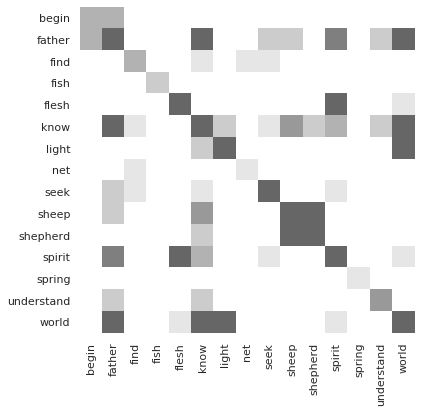

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['figure.figsize'] = (6.0, 6.0)
sns.heatmap(cooc, center=5, cbar=False, cmap="gray_r", robust=True, vmax=6)

In [0]:
# word coocurrence matrix
# https://stackoverflow.com/questions/49431270/word-co-occurrence-matrix-from-gensim


from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary

# somehow create your corpus
dct = Dictionary(sentences_john)
bow_corpus = [dct.doc2bow(line) for line in sentences_john]
term_doc_mat = corpus2csc(bow_corpus)

import numpy as np
term_term_mat = np.dot(term_doc_mat, term_doc_mat.T)

In [0]:
### see https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html

from collections import defaultdict
from gensim import corpora
dictionary = corpora.Dictionary(sentences_john)
corpus = [dictionary.doc2bow(text) for text in sentences_john]

In [0]:
### https://plot.ly/python/sunburst-charts/

import plotly.graph_objects as go

fig =go.Figure(go.Sunburst(
    labels=["Eve", "Cain", "Seth", "Enos", "Noam", "Abel", "Awan", "Enoch", "Azura"],
    parents=["", "Eve", "Eve", "Seth", "Seth", "Eve", "Eve", "Awan", "Eve" ],
    values=[10, 14, 12, 10, 2, 6, 6, 4, 4],
))
# Update layout for tight margin
# See https://plot.ly/python/creating-and-updating-figures/
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig.show()

In [0]:
model = models.HdpModel(corpus, id2word=dictionary)

In [0]:
model

In [0]:
tfidf = models.TfidfModel(corpus)

In [0]:
corpus_tfidf = tfidf[corpus]

In [0]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10)  # initialize an LSI transformation
corpus_lsi = lsi_model[corpus_tfidf]  # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [0]:
import gensim.models

In [0]:
model_john = gensim.models.Word2Vec(sentences=sentences_john, min_count=3, size= 100, window =3, sg = 1)
model_john.wv.most_similar("father", topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('world', 0.8703224658966064),
 ('one', 0.8488008975982666),
 ('spirit', 0.8445515632629395),
 ('come', 0.8383322954177856),
 ('thou', 0.8328428268432617),
 ('say', 0.8298689126968384),
 ('love', 0.8265426158905029),
 ('know', 0.8241018056869507),
 ('hast', 0.8201677799224854),
 ('give', 0.8199243545532227)]

In [0]:
[" ".join(sentence) for sentence in sentences_john]
model_john = gensim.models.LsiModel(sentences_john)


ValueError: ignored

In [0]:
model_john = gensim.models.Word2Vec(sentences=sentences_john, min_count=3, size= 100, window =3, sg = 1)
model_john.wv.most_similar("father", topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('world', 0.8703224658966064),
 ('one', 0.8488008975982666),
 ('spirit', 0.8445515632629395),
 ('come', 0.8383322954177856),
 ('thou', 0.8328428268432617),
 ('say', 0.8298689126968384),
 ('love', 0.8265426158905029),
 ('know', 0.8241018056869507),
 ('hast', 0.8201677799224854),
 ('give', 0.8199243545532227)]

In [0]:
model_john.wv.most_similar(["father"], topn=5)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('world', 0.8612588047981262),
 ('know', 0.8573707342147827),
 ('one', 0.8436732888221741),
 ('thou', 0.8377950191497803),
 ('come', 0.8343890309333801)]

In [0]:
model_john = gensim.models.Word2Vec(sentences=sentences_john, min_count=1, size= 50,workers=3, window =3, sg = 1)
model_thom = gensim.models.Word2Vec(sentences=sentences_thom)


In [0]:
father_john = dict(model_john.wv.most_similar("father", topn=100))
father_thom = dict(model_thom.wv.most_similar("father", topn=100))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
len(set(father_john.keys()) & set(father_thom.keys()))

33

In [0]:
for word set(father_john.keys() ě)

{'abide': 0.30287009477615356,
 'accord': 0.2695857286453247,
 'alone': 0.2535358667373657,
 'also': 0.12684017419815063,
 'another': 0.24794168770313263,
 'ascend': 0.17444980144500732,
 'ask': 0.1365763545036316,
 'authority': 0.1645462065935135,
 'away': 0.1780841052532196,
 'bear': 0.13814666867256165,
 'believe': 0.20450980961322784,
 'branch': 0.2252322882413864,
 'bread': 0.28444814682006836,
 'call': 0.157719224691391,
 'cannot': 0.3311656415462494,
 'choose': 0.12710942327976227,
 'come': 0.2206581085920334,
 'commandment': 0.23471534252166748,
 'condemn': 0.14191247522830963,
 'day': 0.12647464871406555,
 'die': 0.10154435783624649,
 'do': 0.08645559847354889,
 'drink': 0.2815152406692505,
 'eat': 0.15669961273670197,
 'eternal': 0.28391167521476746,
 'every': 0.14171640574932098,
 'evil': 0.09744314849376678,
 'flesh': 0.3237574100494385,
 'fruit': 0.29920077323913574,
 'give': 0.22321844100952148,
 'glorify': 0.08159476518630981,
 'glory': 0.07899129390716553,
 'greater': 0

In [0]:
model_thom.wv.most_similar("father", topn=100)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('spirit', 0.2407652586698532),
 ('soul', 0.21644428372383118),
 ('house', 0.21458619832992554),
 ('invite', 0.1836341917514801),
 ('male', 0.18225133419036865),
 ('seek', 0.14856243133544922),
 ('field', 0.13615953922271729),
 ('heaven', 0.12589597702026367),
 ('hate', 0.12383998930454254),
 ('take', 0.12251702696084976)]

# Appropriate model parametrization

In [0]:
import gensim
from gensim import models
from sklearn.metrics.pairwise import cosine_similarity

### there is a lot of warnings we are not interested in now
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

In [0]:
### all model variants
sgs = [0,1]
sizes = [10, 50, 100]
combinations = []
for sg in sgs:
  for size in sizes:
    combinations.append([sg, size])

In [0]:
combinations_str = ["sg" + str(comb[0]) + "-size" + str(comb[1]) for comb in combinations]
combinations_str

['sg0-size10',
 'sg0-size50',
 'sg0-size100',
 'sg1-size10',
 'sg1-size50',
 'sg1-size100']

In [0]:
target_word = "father" ### we will use the word father for comparing 6 different parametrizations of the model
father_dicts = []
for comb in combinations:
  sim_dict = {}
  model_john = gensim.models.Word2Vec(sentences=sentences_john, min_count= 2, size= comb[1], window = 3, sg = comb[0])
  most_common_words = [word_tup[0] for word_tup in nltk.FreqDist(gospels_cleaned["john"]["words"]).most_common(100)]
  for word in most_common_words:
    sim_dict[word] = cosine_similarity([model_john[target_word], model_john[word]])[0][1]
  father_dicts.append(sim_dict)
### finally, add the default model paramentrization as well
sim_dict = {}
model_john = gensim.models.Word2Vec(sentences=sentences_john)
for word in most_common_words:
  sim_dict[word] = cosine_similarity([model_john[target_word], model_john[word]])[0][1]
father_dicts.append(sim_dict)

In [0]:
father_dicts = pd.DataFrame(father_dicts, index = combinations_str + ["default"])
father_dicts

,father,come,know,world,believe,one,send,truly,give,see,may,god,go,love,life,son,bear,man,speak,word,hear,work,truth,also,yet,would,take,receive,sin,name,light,tell,seek,keep,glorify,sheep,witness,ask,judge,day,...,let,heaven,flesh,drink,fruit,voice,die,mine,call,follow,water,away,moses,authority,place,lay,commandment,testimony,worship,walk,accord,leave,little,joy,indeed,woman,raise,must,lift,never,neither,rejoice,honor,do,good,write,teach,always,law,longer
sg0-size10,1.0,0.371081,-0.124220,0.710724,-0.348886,-0.008991,-0.131486,0.259935,0.518951,0.283558,0.417217,0.241957,0.207503,-0.021201,0.089206,0.304552,-0.115317,-0.308866,0.129420,0.238873,0.197744,0.496596,-0.046223,0.072766,0.266053,-0.203630,0.481911,0.047874,0.088402,0.691733,0.141505,0.415038,0.005721,0.016880,0.137200,-0.438703,-0.360283,0.149166,0.637986,-0.771168,...,0.025950,0.094133,0.062654,-0.029708,0.283157,-0.144081,-0.344404,0.506257,0.209671,0.337101,-0.201777,0.166587,-0.507283,0.159924,-0.080102,-0.329250,-0.243675,0.429121,0.095815,0.268137,0.643406,-0.180421,0.543291,-0.559702,-0.044044,0.317943,0.274909,0.565476,0.153680,0.394738,0.462694,-0.051352,-0.084852,-0.130527,0.535324,0.619508,0.266248,0.100490,-0.355599,-0.094954
sg0-size50,1.0,0.373712,0.164526,0.367964,-0.092811,0.146928,0.284813,-0.008072,0.283307,0.237611,0.172598,0.175036,0.062051,0.193705,0.121490,0.176297,0.106003,0.121068,0.139560,0.231048,0.167648,0.077013,0.365952,0.166283,-0.020030,-0.024815,0.159452,0.167428,0.163841,0.333577,0.001219,0.184614,0.364063,0.308848,0.142946,-0.083758,0.143228,0.030249,0.189921,-0.005360,...,-0.038043,0.188276,0.092541,0.189891,0.063855,0.130805,0.117801,0.163945,0.087737,-0.048305,0.194780,0.294025,-0.026440,0.058493,-0.102959,0.165577,0.033738,0.196431,0.216613,0.201578,0.172909,0.028328,0.182819,-0.101324,0.202296,0.075914,-0.040408,0.236249,-0.013050,0.167610,0.252494,0.156490,0.249356,0.071094,0.148781,0.058038,0.067033,0.259556,0.115968,0.247998
sg0-size100,1.0,0.282211,0.171114,0.176243,0.004788,0.158788,0.035853,0.115439,0.156500,0.087640,0.088336,0.187552,0.034806,0.087812,0.081025,0.229702,0.073829,0.122010,0.088209,0.167540,0.178416,0.041521,0.280352,0.071391,0.037408,0.085144,0.133048,0.079252,0.162548,0.221103,0.043632,-0.094991,0.177179,0.219913,0.094008,-0.042654,0.134366,0.016789,0.075694,0.015615,...,0.112898,0.026348,0.074106,0.057298,0.024477,0.115738,0.035764,0.119252,0.101509,0.117582,0.216820,0.201526,-0.089928,0.026429,-0.005309,0.152914,-0.022467,0.081116,0.208517,0.143718,0.171579,-0.027834,0.106730,-0.089638,0.181924,0.048407,-0.038733,0.226449,0.131449,0.124412,0.110996,0.251325,0.149501,0.115878,0.189264,0.093146,-0.028236,0.171268,0.072305,0.145531
sg1-size10,1.0,0.729724,0.452934,0.923688,0.289299,0.524519,0.540043,0.707097,0.779243,0.650125,0.744454,0.728095,0.667625,0.606354,0.659393,0.637239,0.447579,0.537519,0.541191,0.684608,0.486026,0.663844,0.511326,0.467962,0.565622,0.105878,0.856018,0.378102,0.484106,0.799739,0.529312,0.605753,0.397118,0.601411,0.603277,0.205377,0.213958,0.673835,0.827205,-0.089731,...,0.337141,0.508691,0.510050,0.240158,0.474669,0.184785,0.086775,0.835189,0.440412,0.365632,0.321621,0.600502,-0.056070,0.553988,0.457852,0.314126,0.248669,0.710165,0.500612,0.533082,0.831844,0.100908,0.763197,-0.079310,0.127440,0.276727,0.601666,0.780704,0.360502,0.742660,0.739898,0.334517,0.236737,0.187122,0.802054,0.614366,0.385523,0.378954,0.428913,0.072726
sg1-size50,1.0,0.753201,0.657443,0.768149,0.435776,0.578439,0.720117,0.478879,0.682943,0.688986,0.649592,0.550141,0.614058,0.637344,0.585525,0.549100,0.578128,0.618114,0.530500,0.634017,0.564261,0.525310,0.728260,0.601737,0.384425,0.408884,0.602746,0.384943,0.613394,0.616318,0.470668,0.437374,0.661768,0.623317,0.508130,0.233902,0.524772,0.556624,0.551696,0.502599,...,0.364033,0.506424,0.533850,0.486278,0.495687,0.393437,0.500409,0.455553,0.511139,0.133385,0.515341,0.596878,0.329204,0.457338,0.419543,0.464262,0.296720,0.465631,0.434415,0.483984,0.495034,0.403

In [0]:
### evaluate similarity values across various versions of the model
from scipy.stats import pearsonr
for pair_0 in range(7):
  for pair_1 in range(7):
    print(pair_0, pair_1, pearsonr(father_dicts.iloc[pair_0], father_dicts.iloc[pair_1]))

0 0 (1.0, 0.0)
0 1 (0.46286936986386434, 1.2417857880200074e-06)
0 2 (0.39151328493228355, 5.626978014717822e-05)
0 3 (0.835389667564501, 3.240057578790692e-27)
0 4 (0.26920438019501486, 0.00676105418303121)
0 5 (0.20764077930714997, 0.03817669732693286)
0 6 (0.40194855772672167, 3.3954610118910784e-05)
1 0 (0.46286936986386434, 1.2417857880200074e-06)
1 1 (0.9999999999999999, 0.0)
1 2 (0.8210652923297285, 1.3389108518233045e-25)
1 3 (0.45748010056341365, 1.7085652794104944e-06)
1 4 (0.7665801024322653, 1.4653922954764722e-20)
1 5 (0.6342118071302668, 1.4031786331408148e-12)
1 6 (0.7819927326848777, 7.740464937583155e-22)
2 0 (0.39151328493228355, 5.626978014717822e-05)
2 1 (0.8210652923297285, 1.3389108518233045e-25)
2 2 (1.0, 0.0)
2 3 (0.37171067430466087, 0.00014023694629861284)
2 4 (0.6082469580968353, 1.918311912513674e-11)
2 5 (0.7251785633716957, 1.443077807470611e-17)
2 6 (0.9734244444711811, 1.520956361097469e-64)
3 0 (0.835389667564501, 3.240057578790692e-27)
3 1 (0.457480100